In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d aryashah2k/mango-leaf-disease-dataset

 99% 102M/103M [00:04<00:00, 28.8MB/s] 
100% 103M/103M [00:04<00:00, 23.8MB/s]


In [5]:
from zipfile import ZipFile

with ZipFile('mango-leaf-disease-dataset.zip', 'r') as f:

 #extracting in directory 'images'
 f.extractall('images')

In [6]:
import os
import shutil
import random

root_folder = "/content/images" 
train_ratio = 0.7  
val_ratio = 0.15  
test_ratio = 0.15  

#list of subfolders (labels)
subfolders = [f.name for f in os.scandir(root_folder) if f.is_dir()]

for subfolder in subfolders:
    subfolder_path = os.path.join(root_folder, subfolder)
    images = [f.name for f in os.scandir(subfolder_path) if f.is_file()]

    random.shuffle(images)

    num_images = len(images)
    num_train = int(num_images * train_ratio)
    num_val = int(num_images * val_ratio)
    num_test = num_images - num_train - num_val

    train_images = images[:num_train]
    val_images = images[num_train:num_train + num_val]
    test_images = images[num_train + num_val:]

    train_dir = os.path.join(root_folder, 'train', subfolder)
    val_dir = os.path.join(root_folder, 'val', subfolder)
    test_dir = os.path.join(root_folder, 'test', subfolder)
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    for image in train_images:
        src = os.path.join(subfolder_path, image)
        dst = os.path.join(train_dir, image)
        shutil.move(src, dst)

    for image in val_images:
        src = os.path.join(subfolder_path, image)
        dst = os.path.join(val_dir, image)
        shutil.move(src, dst)

    for image in test_images:
        src = os.path.join(subfolder_path, image)
        dst = os.path.join(test_dir, image)
        shutil.move(src, dst)

    os.rmdir(subfolder_path)

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Preprocessing the Training dataset
train_datagen = ImageDataGenerator(rescale=1./255)
training_set = train_datagen.flow_from_directory('/content/images/train',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'binary')


Found 2800 images belonging to 8 classes.


In [9]:
# Preprocessing the Test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory('/content/images/test',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 600 images belonging to 8 classes.


In [14]:
from tensorflow.keras.layers import Flatten
from keras.layers.pooling.max_pooling2d import MaxPool2D
from tensorflow.keras.layers import LeakyReLU
import tensorflow as tf
from keras.api._v2.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2

cnn = tf.keras.models.Sequential()

#  Convolution
cnn.add(tf.keras.layers.Conv2D(filters=32,padding="same",kernel_size=3, activation='relu', strides=2, input_shape=[64, 64, 3]))
cnn.add(LeakyReLU(alpha=0.2))

cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))


cnn.add(Conv2D(filters=64, kernel_size=3, padding='same', strides=1))
cnn.add(LeakyReLU(alpha=0.2))
cnn.add(MaxPool2D(pool_size=2, strides=2))

cnn.add(Conv2D(filters=128, kernel_size=3, padding='same', strides=1))
cnn.add(LeakyReLU(alpha=0.2))
cnn.add(MaxPool2D(pool_size=2, strides=2))

cnn.add(Flatten())

cnn.add(Dense(units=256))
cnn.add(LeakyReLU(alpha=0.2))
cnn.add(BatchNormalization())

cnn.add(Dense(units=1, activation='linear', kernel_regularizer=l2(0.01)))

In [15]:
cnn.add(Dense(4, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation
             ='softmax'))
cnn.compile(optimizer = 'adam', loss = 'squared_hinge', metrics = ['accuracy'])
cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                  

In [27]:
from tensorflow.keras.optimizers import Adam
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)
# Compiling the CNN
cnn.compile(optimizer = optimizer, loss = 'hinge', metrics = ['accuracy'])

# Training the CNN on the Training set and evaluating it on the Test set
r=cnn.fit(x = training_set, validation_data = test_set, epochs = 12)

Epoch 1/12
88/88 [==============================] - 17s 166ms/step - loss: 0.8973 - accuracy: 0.1532 - val_loss: 0.9123 - val_accuracy: 0.1250
Epoch 2/12
88/88 [==============================] - 15s 175ms/step - loss: 0.8900 - accuracy: 0.1514 - val_loss: 0.9052 - val_accuracy: 0.1250
Epoch 3/12
88/88 [==============================] - 15s 175ms/step - loss: 0.8855 - accuracy: 0.1514 - val_loss: 0.8910 - val_accuracy: 0.1400
Epoch 4/12
88/88 [==============================] - 14s 163ms/step - loss: 0.8757 - accuracy: 0.1514 - val_loss: 0.8828 - val_accuracy: 0.1483
Epoch 5/12
88/88 [==============================] - 16s 179ms/step - loss: 0.8612 - accuracy: 0.1457 - val_loss: 0.8636 - val_accuracy: 0.1450
Epoch 6/12
88/88 [==============================] - 14s 161ms/step - loss: 0.8455 - accuracy: 0.1364 - val_loss: 0.8494 - val_accuracy: 0.1350
Epoch 7/12
88/88 [==============================] - 14s 162ms/step - loss: 0.8307 - accuracy: 0.1261 - val_loss: 0.8346 - val_accuracy: 0.1200

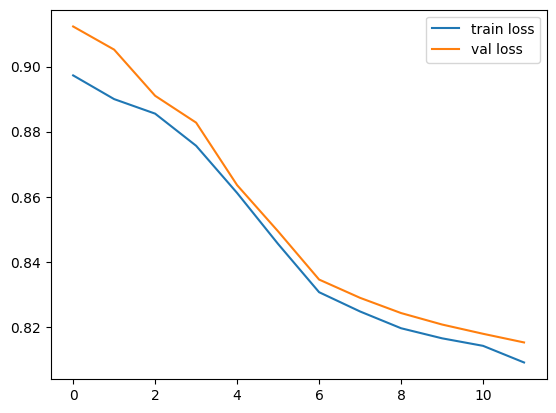

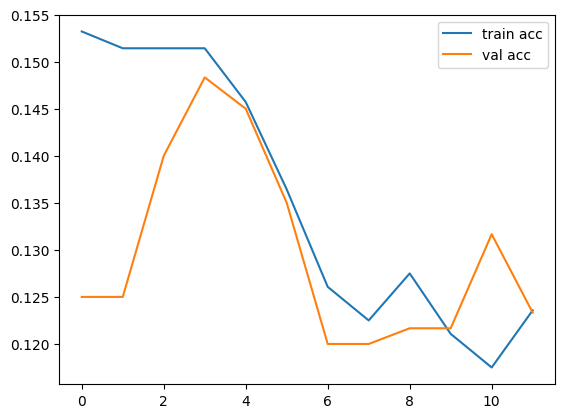

<Figure size 640x480 with 0 Axes>

In [29]:

import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# ploting the model accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

References:
https://www.youtube.com/watch?v=upo34AT1Cys